<a href="https://colab.research.google.com/github/maxskoda/RefNX_GUI_v1/blob/master/Bilayer_On_Gold_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Installs
!pip install refnx
!pip install gspread

In [135]:
# @title Imports

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

from IPython.display import Javascript

import pandas as pd
import re
import re
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

from refnx.reflect import SLD, Slab, ReflectModel, MixedReflectModel, FunctionalForm, Structure, sld_profile, Stack
from refnx.analysis import Objective, GlobalObjective, Parameter, CurveFitter, Transform, process_chain

from refnx.dataset import ReflectDataset

from google.colab import sheets

In [136]:
# @title Helper functions

# Function to create parameters from the table
def create_parameter(name, value, lower, upper, vary, dist_type, param1, param2):
    if dist_type == 'uniform':
        return Parameter(value, name=name, bounds=(lower, upper), vary=vary)
    elif dist_type == 'gaussian':
        return Parameter(value, name=name, bounds=stats.norm(param1, param2), vary=vary)

# Function to convert Google sheet to csv format
def convert_gglsht_url(url):
    pattern = r'https://docs\.google\.com/spreadsheets/d/([a-zA-Z0-9-_]+)(/edit#gid=(\d+)|/edit.*)?'
    replacement = lambda m: f'https://docs.google.com/spreadsheets/d/{m.group(1)}/export?' + (f'gid={m.group(3)}&' if m.group(3) else '') + 'format=csv'
    new_url = re.sub(pattern, replacement, url)
    return new_url

In [137]:
# @title Data entry sheets

# Create a new interactive sheet and add data to it.
# sheet = sheets.InteractiveSheet()

# Open existing sheet
sheet = gc.open('RefNX Parameter Table')

In [138]:
# @title Refresh spreadsheet and re-generate parameters
# url = 'https://docs.google.com/spreadsheets/d/1aGrL-jpTJ-cuIqSGuJtwt4svpAMQA2-I3nzZrknrnvo/edit?gid=0#gid=0'
# new_url = convert_gglsht_url(url)
# print(new_url)

def refresh_spreadsheet():
  # Open the Google Sheet using its key
  sheet = gc.open_by_key('1aGrL-jpTJ-cuIqSGuJtwt4svpAMQA2-I3nzZrknrnvo')

  # Get the first worksheet
  worksheet = sheet.get_worksheet(0)

  # Convert the worksheet to a Pandas DataFrame
  df = pd.DataFrame(worksheet.get_all_records())
  # df

  parameters = {}
  for index, row in df.iterrows():
      parameters[row['Name']] = create_parameter(
          name=row['Name'],
          value=row['Initial Value'],
          lower=row['Lower Bound'],
          upper=row['Upper Bound'],
          vary=row['Vary'] == 'TRUE',
          dist_type=row['Type'],
          param1=row['Type Param 1'],
          param2=row['Type Param 2']
      )
  return parameters

parameters = refresh_spreadsheet()

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='z / $\\AA$', ylabel='SLD / 1e-6 $\\AA^{-2}$'>)

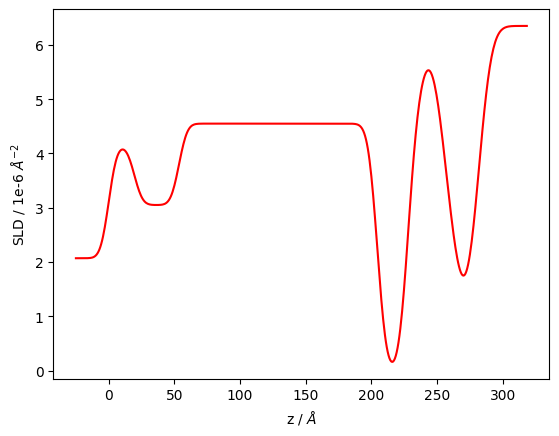

In [140]:
# @title Generate and plot structure

# execute function above to re-genearate parameters from spreadsheet
parameters = refresh_spreadsheet()

# Open the 'Layers' worksheet
worksheet_layers = sheet.worksheet('Layers')

# Convert the worksheet to a Pandas DataFrame
df_layers = pd.DataFrame(worksheet_layers.get_all_records())

# Create a list to store the layers
layers = []

# Iterate through the rows in the DataFrame
for index, row in df_layers.iterrows():
  # Get the layer name, thickness, SLD, and roughness parameters
  thickness_param_name = row['Thickness']
  sld_param_name = row['SLD']
  roughness_param_name = row['Roughness']
  hydration = row['Hydration']

  # Create the Slab object using the parameters from the table
  layer = Slab(
      name=row['Layer Name'],
      thick=parameters[thickness_param_name],
      sld=parameters[sld_param_name],
      rough=parameters[roughness_param_name] if roughness_param_name in parameters else Parameter(5), # Default roughness to 5 if not specified
      vfsolv=parameters[hydration]/100 if hydration in parameters else Parameter(0) # Default to no hydration if not specified
  )

  # Add the layer to the list
  layers.append(layer)

si = SLD(2.07, name='Si substrate')
d2o = SLD(6.35, name='D2O subphase')

# Create the structure using the list of layers
structure = si(0, 6)
for layer in layers:
  structure = structure | layer

# Add the last layer
structure = structure | d2o(0, parameters['Bilayer rough'])
# print(structure)

# Plot the structure
structure.plot()
